In [85]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
data=pd.read_csv("example_air_passengers.csv", parse_dates=["ds"],
    index_col=["ds"],)

In [87]:
data.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


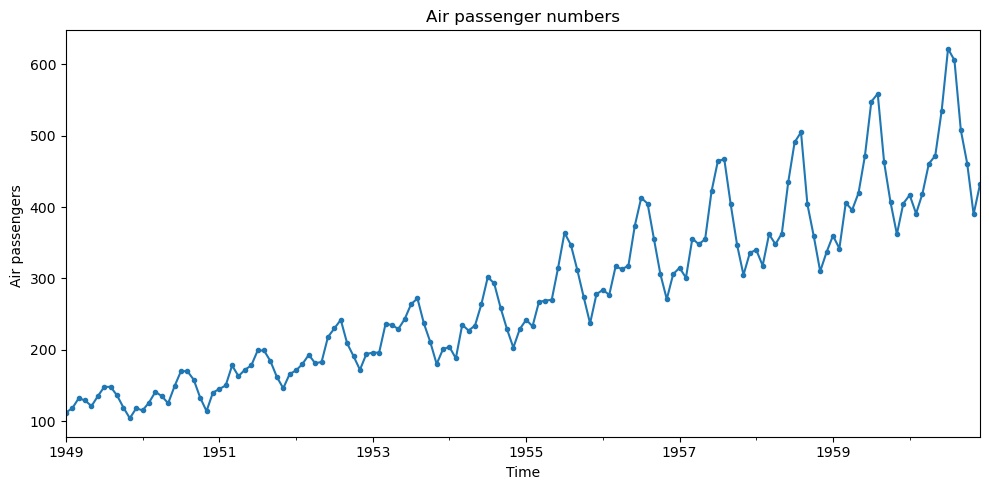

In [88]:
fig, ax = plt.subplots(figsize=[12, 6])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers ")
ax.set_title("Air passenger numbers")
plt.tight_layout()

## Creating Time feature to capture trend

In [89]:
df= data.copy()

In [90]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [91]:
df["T"]=np.round((df.index-df.index.min())/np.timedelta64(1,"M"))

In [92]:
df.head()

,y,T
ds,,
1949-01-01,112,0.0
1949-02-01,118,1.0
1949-03-01,132,2.0
1949-04-01,129,3.0
1949-05-01,121,4.0


# TimeSince transformer from sktime

In [93]:
df=data.copy()

In [94]:
from sktime.transformations.series.time_since import TimeSince

In [95]:
transformer=TimeSince(
start=["1949-01-01", "1949-02-01"], #list of start date
to_numeric=True,
freq="MS",
positive_only=False,  # Set negative values to zero.
keep_original_columns=False,# Keep the other columns in the dataframe
)

In [96]:
transformer.fit(df)

TimeSince(freq='MS', start=['1949-01-01', '1949-02-01'])

In [97]:
   print( [
        transformer.start,
        transformer.freq,
    ]
)

[['1949-01-01', '1949-02-01'], 'MS']


In [98]:
transformer.transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-02-01 00:00:00
ds,,
1949-01-01,0,-1
1949-02-01,1,0
1949-03-01,2,1
1949-04-01,3,2
1949-05-01,4,3
...,...,...
1960-08-01,139,138
1960-09-01,140,139
1960-10-01,141,140


# If we do not specify the start dates then the transformer will automatically use the earliest date in the dataframe.

In [99]:
transformer = TimeSince(keep_original_columns=True)
transformer.fit_transform(df)

,y,time_since_1949-01-01 00:00:00
ds,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4
...,...,...
1960-08-01,606,139
1960-09-01,508,140
1960-10-01,461,141


In [100]:
# Building forcasting model with Time feature only

In [101]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [102]:
df=data.copy()

In [103]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [104]:
# lets do it for 24 data point for reserve

In [105]:
holdout_size=24
df_train=df.iloc[:-holdout_size]
df_test=df.iloc[-holdout_size:]

In [106]:
# Fit the transformer
transformer = TimeSince(keep_original_columns=True, freq="MS")
transformer.fit(df_train)

TimeSince(freq='MS', keep_original_columns=True)

In [107]:
# Create the time feature
df_train = transformer.transform(df_train)
df_test = transformer.transform(df_test)

In [108]:
df_train.head()

,y,time_since_1949-01-01 00:00:00
ds,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4


In [109]:
df_train.tail()

,y,time_since_1949-01-01 00:00:00
ds,,
1958-08-01,505,115
1958-09-01,404,116
1958-10-01,359,117
1958-11-01,310,118
1958-12-01,337,119


In [110]:
df_test.head()

,y,time_since_1949-01-01 00:00:00
ds,,
1959-01-01,360,120
1959-02-01,342,121
1959-03-01,406,122
1959-04-01,396,123
1959-05-01,420,124


X and y for training and testing

In [111]:
features = ["time_since_1949-01-01 00:00:00"]
target = ["y"]

y_train = df_train[target]
X_train = df_train[features]

y_test = df_test[target]
X_test = df_test[features]

In [112]:
model = LinearRegression()
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

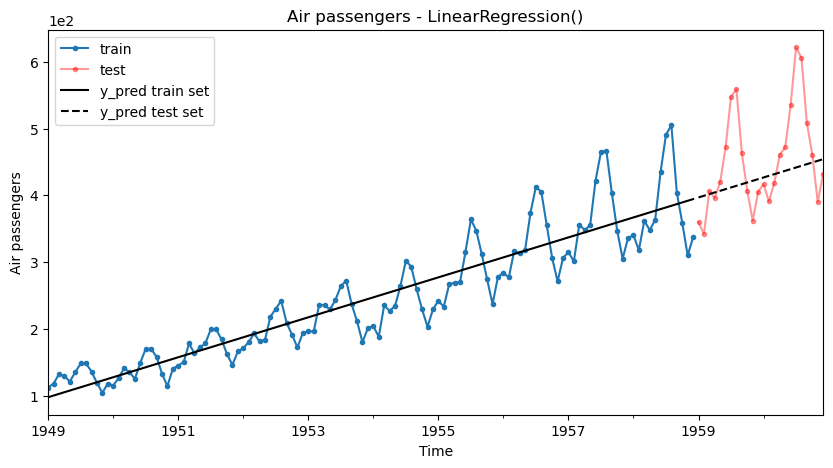

In [113]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))


## Lets see Decision tree

In [114]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

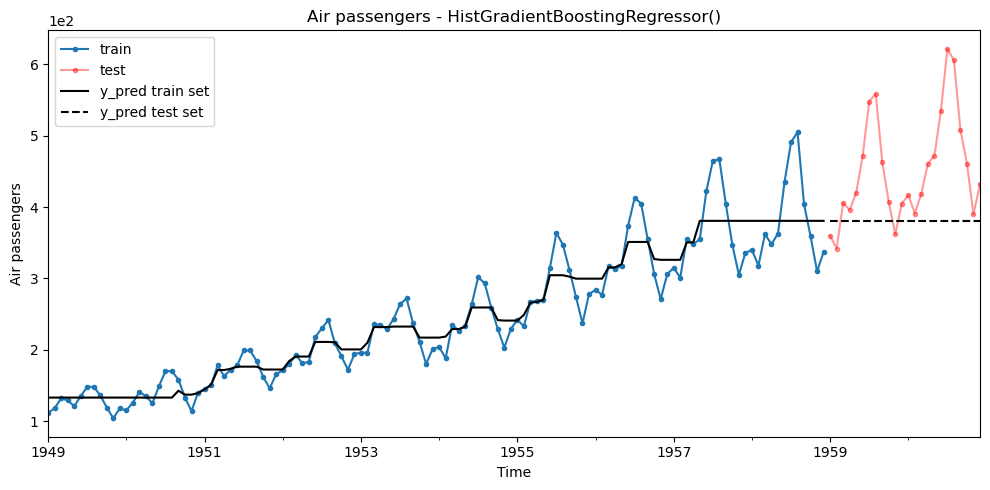

In [116]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

In [117]:
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)


C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


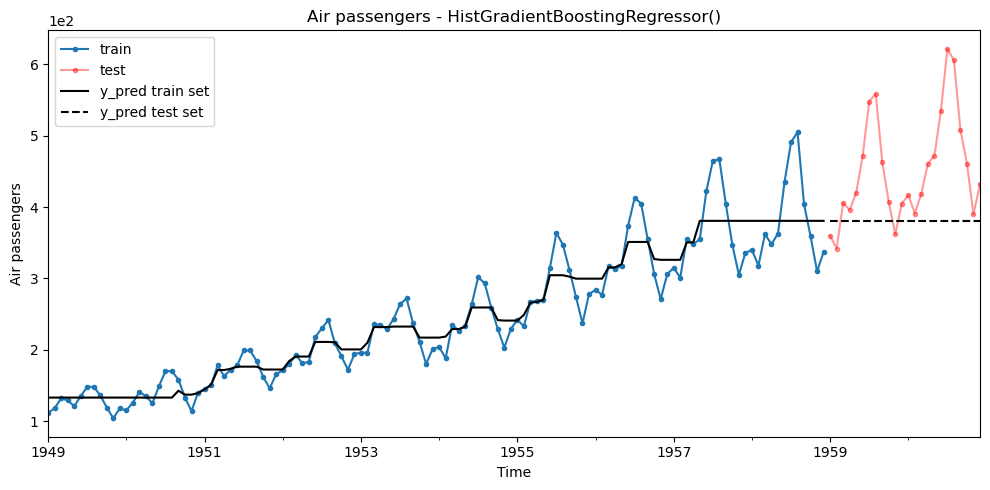

In [118]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

#### Fordward looking forcast

In [119]:
df=data.copy()

In [120]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [124]:
forecast_start_point = df.index[-1] + pd.DateOffset(months=1)
# forecasting horizon
fh = pd.date_range(
    start=forecast_start_point,  # first period after the
                                 # end of our time series
    freq="MS",
    periods=12,  # forecast 12 periods into the future
)

# Create our features for our training and prediction periods

df_train = df  # Train over the whole dataset
df_predict = pd.DataFrame(index=fh)  # Predict over our forecast horizon

display(df_predict)


""
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01
1961-06-01
1961-07-01
1961-08-01
1961-09-01
1961-10-01


In [125]:
transformer = TimeSince(
    start=[pd.to_datetime("1970-02-01")],  # Pick a start date
                                           # far in future to
                                           # show it has no impact.
    freq="MS",
    keep_original_columns=True,
)

df_train = transformer.fit_transform(df_train)
df_predict = transformer.transform(df_predict)

In [126]:
display(df_train.head(), df_predict.head())

,y,time_since_1970-02-01 00:00:00
ds,,
1949-01-01,112,-253
1949-02-01,118,-252
1949-03-01,132,-251
1949-04-01,129,-250
1949-05-01,121,-249


,time_since_1970-02-01 00:00:00
1961-01-01,-109
1961-02-01,-108
1961-03-01,-107
1961-04-01,-106
1961-05-01,-105


In [127]:
features = ["time_since_1970-02-01 00:00:00"]
target = ["y"]

y_train = df_train[target]
X_train = df_train[features]

X_test = df_predict[features]

In [128]:
model = LinearRegression()
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)


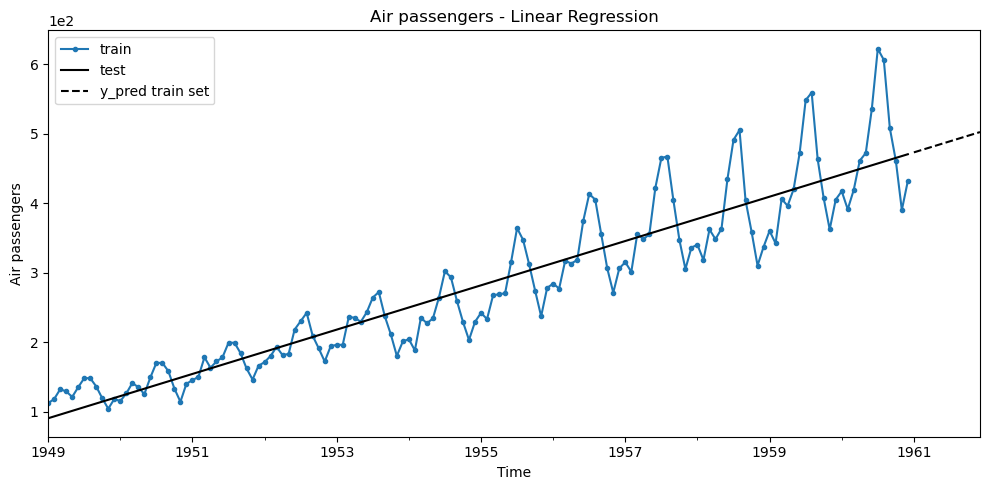

In [129]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title("Air passengers - Linear Regression")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()